# 0. Import pacakges

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, normalize, minmax_scale
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# 1. Load data

**We think it's necessary to normalize the data we have. Usually recommender system applies for rating data which  is usually in (0,5) scale. See https://www.quora.com/How-do-I-build-a-recommendation-system-using-transaction-data-quantity-purchased-sales-How-do-I-convert-the-transaction-table-to-rating-table for reference **

** The data manipulation part is in the R code**
- *customer* is the customer-[sub]category table
- *cat_list* contains name and ID of each category
- *sub_list* contains name and ID of each subcategory

In [2]:
customer = pd.read_csv('sub_2017.csv')
sub_list = pd.read_csv('subcategory_list.csv')
cat_list = pd.read_csv('cat_list.csv')
customer = customer.fillna(0)

In [3]:
customer_id = list(customer['cust_id'])


** Only keep those customers with annual purchasing over 5000**

In [8]:
customer_5k = customer[customer['Sum_2017'] > 5000]

In [9]:
column_max = np.max(customer_5k)

In [10]:
customer_scaled = pd.DataFrame(minmax_scale(customer_5k,  feature_range=(0, 1),axis = 0))

In [11]:
customer_scaled.columns = customer.columns
customer_scaled['cust_id'] = customer['cust_id']

In [12]:
customer_scaled.index = customer_5k.index

In [13]:
cat = customer_scaled.iloc[:,range(-431,-1)]
subcat = customer_scaled.iloc[:,range(1,customer.shape[1]-431)]
cat_original = customer_5k.iloc[:, range(-431, -1)]
subcat_original = customer_5k.iloc[:,range(1, customer.shape[1]-431)]

** Keep original indexes **

In [14]:
indexes = list(cat.columns)

In [15]:
for i in range(430):
    if indexes[i] == 'Sum':
        indexes[i] = 430
    else:
        if indexes[i] == 'i.Sum':
            indexes[i] = 429
        else:
            indexes[i] = int(indexes[i].split('.')[2])
cat.columns = indexes
cat_original.columns = indexes


In [16]:
indexes = list(subcat.columns)

In [17]:
for i in range(1476):
    if indexes[i] == 'SubSum':
        indexes[i] = 1476
    else:
        if indexes[i] == 'i.SubSum':
            indexes[i] = 1475
        else:
            indexes[i] = int(indexes[i].split('.')[2])
subcat.columns = indexes
subcat_original.columns = indexes

# 2. Clustering based on categories

## 2.0 KMeans 

In [18]:
sse = {}

In [19]:
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(cat)
    sse[k] = kmeans.inertia_

In [20]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

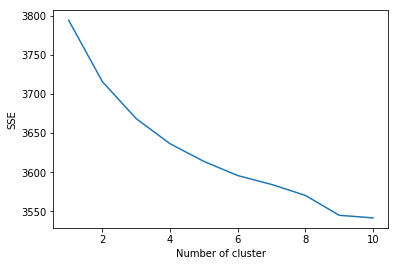

In [21]:
plt.show()

** According to the elbow method, the best k for KMeans is 9 **

In [22]:
kmeans9 = KMeans(n_clusters = 9, random_state = 0).fit(cat)
cluster9 = kmeans9.labels_ 

** The number of customers in each group is: **

In [23]:
pd.Series(cluster9).value_counts()

7    401
0    273
3    265
1    221
8    198
2    196
6    153
5    121
4     69
dtype: int64

## 2.1 Take a look into each group -- top category in each group

In [24]:
cat['category'] = cluster9

/Users/leoma/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


** For each group, what are their top categories, comparing to the whole population? **

In [26]:
for i in range(9):
    cat_i = cat[cat['category'] == i]
    print('For group %d'%(i))
    top10 = pd.DataFrame(cat_i.sum(axis=0)).sort_values(by = 0, ascending = False).index[range(1,11)]
    for j in list(top10):
        print(cat_list[cat_list['id'] == j]['category_desc_eng'])

For group 0
145    GARLIC
Name: category_desc_eng, dtype: object
158    ONION
Name: category_desc_eng, dtype: object
135    BUTTER
Name: category_desc_eng, dtype: object
252    BAGS
Name: category_desc_eng, dtype: object
166    FRESH POULTRY MEAT
Name: category_desc_eng, dtype: object
202    CURRENT UHT MILK
Name: category_desc_eng, dtype: object
29    TOILET PAPER
Name: category_desc_eng, dtype: object
25    FINE WAFERS
Name: category_desc_eng, dtype: object
340    LETTUCE
Name: category_desc_eng, dtype: object
34    CANNED VEGETABLES
Name: category_desc_eng, dtype: object
For group 1
25    FINE WAFERS
Name: category_desc_eng, dtype: object
53    BREAKFAST CEREALS
Name: category_desc_eng, dtype: object
21    PACKAGED BREAD
Name: category_desc_eng, dtype: object
46    FRUIT JUICES
Name: category_desc_eng, dtype: object
202    CURRENT UHT MILK
Name: category_desc_eng, dtype: object
2    YOGURT DRINK
Name: category_desc_eng, dtype: object
29    TOILET PAPER
Name: category_desc_eng, dtype

# 3. Recommender for each group

In [27]:
subcat_original['category'] = cluster9
subcat['category'] = cluster9
recommended_amount = pd.DataFrame()

/Users/leoma/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/leoma/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


** Use the SVD approach for recommender system**

In [28]:
for i in range(9):
    subcat_i = subcat[subcat['category'] == i]
    subcat_i = subcat_i.iloc[:,0:1476]
    subcat_original_i = subcat_original[subcat_original['category'] == i]
    subcat_original_i = subcat_original_i.iloc[:,0:1476]
    u, s, vt = svds(subcat_i, k = 20)
    s_diag_matrix = np.diag(s)
    X_pred = pd.DataFrame(np.dot(np.dot(u, s_diag_matrix), vt))
    for j in range(X_pred.shape[1]):
        X_pred.iloc[:,j] = X_pred.iloc[:,j] * column_max[j + 1]
    X_pred.columns = subcat_i.columns
    X_pred.index = subcat_i.index
    recommended_amount = recommended_amount.append(X_pred - subcat_original_i)

In [29]:
recommended_amount = recommended_amount.sort_index()

In [80]:
recommended_sub = pd.DataFrame()

** For each customer, recommend FIVE subcategories depending on gap of predicted amount and their actual spending **

In [81]:
for i in range(recommended_amount.shape[0]):
    recommended_sub[recommended_amount.index[i]] = list(pd.DataFrame(recommended_amount.iloc[i,:]).sort_values(by = recommended_amount.index[i]).index[[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]].T)

In [82]:
recommended_sub

,0,1,3,5,16,17,19,20,36,37,...,7884,7885,7886,7888,7894,7906,7910,7911,7913,7914
0,22,37,160,85,200,200,1020,153,349,2,...,195,160,461,369,29,280,1173,414,280,161
1,102,43,28,126,399,1347,126,30,577,78,...,280,22,392,153,126,28,586,64,200,394
2,220,532,245,1020,369,870,30,884,179,5,...,220,5,162,152,28,30,573,148,1020,160
3,39,841,153,838,161,107,884,179,537,369,...,245,112,1327,150,396,537,126,98,160,98
4,153,280,577,545,414,1230,39,392,5,870,...,85,102,1448,838,133,220,162,30,30,39
5,5,98,461,399,162,1020,43,32,85,61,...,161,28,43,30,1173,414,245,280,884,37
6,884,143,29,537,884,280,29,844,126,29,...,367,220,30,2,1016,245,461,5,32,179
7,30,396,30,178,844,857,537,399,1188,884,...,1020,85,214,5,280,32,392,537,545,153
8,461,28,107,150,107,884,85,162,30,245,...,537,107,153,39,32,85,39,126,22,198
9,107,107,85,421,245,414,107,107,107,32,...,32,32,844,399,179,844,884,32,85,32


In [83]:
recommended_for_customer = recommended_sub.T

In [84]:
recommended_for_customer['no'] = pd.Series(customer_id)[recommended_for_customer.index]

In [85]:
recommended_for_customer.to_csv('recommended_for_customer.csv', index = True)

In [86]:
recommended_sub_array = recommended_sub.as_matrix().reshape(-1,1)

** Count the most common subcategories **

In [87]:
recommended_list = pd.DataFrame(pd.DataFrame(recommended_sub_array)[0].value_counts())

In [88]:
recommended_list['name'] = sub_list.iloc[recommended_list.index,1]

In [89]:
recommended_list['id'] = sub_list.iloc[recommended_list.index,0]

In [90]:
recommended_list.columns = ['count', 'name', 'id']

In [91]:
recommended_list.to_csv('recommended_sub_list.csv')

*Following analysis is in Microsoft Excel*